## Context Aware Image Resizing via Seam Carving
### CS 445 
### Manas Gandhi (algorithm lead) and Anwith Telluri (data and image lead)

### Based on the following paper by Shai Avidan and Ariel Shamir: Seam Carving for Content-Aware Image Resizing

In [68]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm # For progress bars

In [69]:
#helper function to display images
def show_comparison(original, carved, scaled, title_prefix):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title(f"Original: {title_prefix}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(scaled)
    plt.title("Standard Scaling")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(carved)
    plt.title("Seam Carving")
    plt.axis('off')

    plt.show()

In [87]:
#load images
IMG_DIR = './images'
FILES = {
    'success_balloon': 'success_balloon.jpg',
    'success_landscape': 'success_landscape.jpg',
    'failure_crowd': 'failure_crowd.jpg',
    'failure_pogoda': 'failure_pogoda.jpg',
    'success_boat': 'success_boat.jpg',
    'success_plane': 'success_plane.jpg',
    
}

success_keys = ['success_landscape', 'success_balloon']
success_keys_widening = ['success_boat', 'success_plane']

failure_keys = ['failure_crowd', 'failure_pogoda']
all_keys = ['success_landscape', 'success_balloon', 'failure_crowd', 'failure_pogoda']
loaded_images = {}

for key, filename in FILES.items():
    path = os.path.join(IMG_DIR, filename)
    img = cv2.imread(path)
    
    if img is not None:
        # Convert BGR (OpenCV default) to RGB (Matplotlib default)
        loaded_images[key] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print(f"Loaded {key}: {filename} | Size: {loaded_images[key].shape[1]}x{loaded_images[key].shape[0]}")
    else:
        print(f"Error: Could not find {filename} in {IMG_DIR}")

Loaded success_balloon: success_balloon.jpg | Size: 600x400
Loaded success_landscape: success_landscape.jpg | Size: 600x400
Loaded failure_crowd: failure_crowd.jpg | Size: 600x400
Loaded failure_pogoda: failure_pogoda.jpg | Size: 600x480
Loaded success_boat: success_boat.jpg | Size: 275x183
Loaded success_plane: success_plane.jpg | Size: 600x400


## Step 1: Energy Function Calculation

The first step is to compute the energy map of the image. As per the paper and our proposal, we use the $L_1$ norm of the gradient. We utilize the Sobel operator to calculate the gradients in $x$ and $y$ directions. High energy corresponds to edges and important features, while low energy corresponds to smooth backgrounds (like trees or water).

We implement the energy function:
$$e_1(I) = \left| \frac{\partial}{\partial x}I \right| + \left| \frac{\partial}{\partial y}I \right|$$

as defined in Equation 1 of the paper.

In [71]:
#computes energy map of the image using the L1 norm of gradients.
def calculate_energy(img):
    #formula from paper: e1(I) = |dI/dx| + |dI/dy|
    #grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #gaussian blur to calculate energy better
    gray_blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    #ger=t gradients on the blurred image
    dx = cv2.Sobel(gray_blurred, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(gray_blurred, cv2.CV_64F, 0, 1, ksize=3)
    
    # 4. L1 Norm
    energy_map = np.abs(dx) + np.abs(dy)
    
    return energy_map

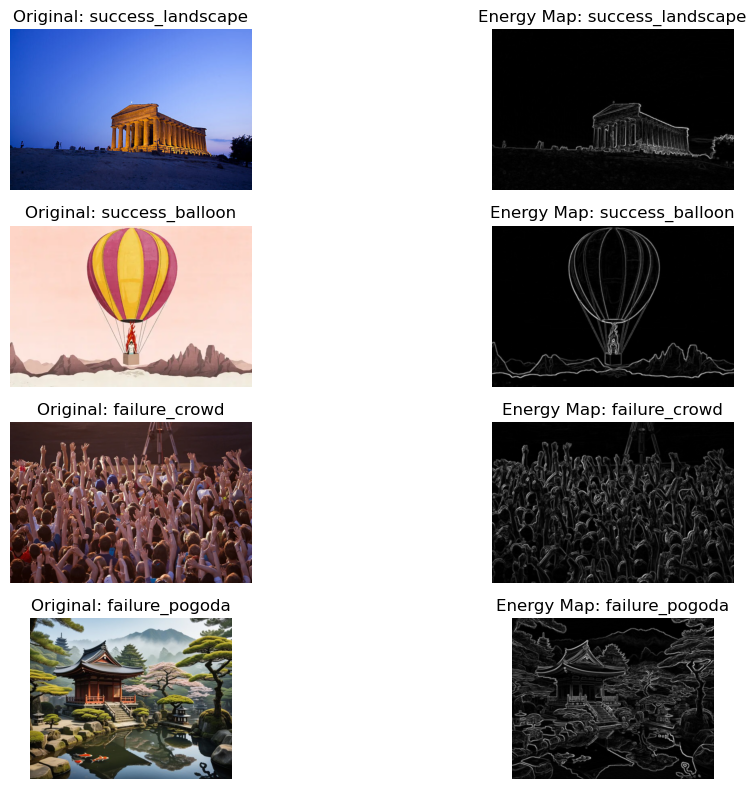

In [72]:
debug_keys = ['success_landscape', 'success_beach']

plt.figure(figsize=(12, 8))

for i, key in enumerate(all_keys):
    if key not in loaded_images: continue

    img = loaded_images[key]
    
    energy = calculate_energy(img)
    
    #original image
    plt.subplot(len(all_keys), 2, 2*i + 1)
    plt.imshow(img)
    plt.title(f"Original: {key}")
    plt.axis('off')

    #energy img    
    plt.subplot(len(all_keys), 2, 2*i + 2)
    plt.imshow(energy, cmap='gray')
    plt.title(f"Energy Map: {key}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Step 2: Dynamic Programming (Cost Matrix)

To find the optimal vertical seam, we need to find a path from top to bottom that has the minimum accumulated energy. We set $M(i, j)$ as the cumulative minimum energy at pixel $(i, j)$.

The recurrence relation is given by Equation 6 in the paper:
$$M(i, j) = e(i, j) + \min(M(i-1, j-1), M(i-1, j), M(i-1, j+1))$$

This ensures that the seam is connected to neighbors directly above or diagonally above it.

In [73]:
def compute_cost_matrix(energy_map):
    """
    Computes the cumulative minimum energy matrix M using Dynamic Programming.
    """
    rows, cols = energy_map.shape
    M = energy_map.copy()
    
    #store direction we came from to reconstruct the seam later
    #0 = top left, 1 = top, 2 = top right
    backtrack = np.zeros_like(M, dtype=int)

    for i in range(1, rows):
        for j in range(cols):
            #boundary conditions (left and right edges)
            if j == 0:
                idx = np.argmin(M[i-1, j:j+2])
                backtrack[i, j] = idx + 1
                min_energy = M[i-1, j + idx]
            else:
                #look at neighbors by slicing M[i-1, j-1:j+2]
                neighbors = M[i-1, max(0, j-1): min(cols, j+2)]
                idx = np.argmin(neighbors)
                
                #store relative offset
                min_energy = neighbors[idx]
                
                #index mapping for backtrack
                backtrack[i, j] = idx 
                
        M[i, j] += min_energy
        
    return M, backtrack

## Step 3: Finding and Removing the Seam

Once the cost matrix $M$ is computed, the minimum value in the last row indicates the end of the optimal vertical seam. We then backtrack from this point to the top of the image to identify the full path.

After identifying the coordinates of the seam, we remove those pixels. This shifts all pixels to the right of the seam one step to the left, effectively reducing the image width by 1 pixel.

In [74]:
#finds the coordinates of the vertical seam with the lowest energy
def find_vertical_seam(M, backtrack):
    rows, cols = M.shape
    
    #find starting point at the bottom row (minimum cumulative energy)
    j = np.argmin(M[-1])
    
    seam_idx = []
    
    #backtrack to the top
    for i in range(rows-1, -1, -1):
        seam_idx.append(j)
        
        #get col index of the pixel in the row above
        # backtrack[i, j] stores: 0 = j-1, 1 = j, 2 = j+1
        offset = backtrack[i, j] - 1
        j = np.clip(j + offset, 0, cols - 1)
        
    #rewturn (row, col) coords top to bottom
    return np.array(seam_idx)[::-1]

#removes the vertical seam from the image
def remove_vertical_seam(img, seam_idx):
    rows, cols, _ = img.shape
    
    #width - 1 img
    new_img = np.zeros((rows, cols - 1, 3), dtype=np.uint8)
    
    for i in range(rows):
        #find col to remove
        col_to_remove = seam_idx[i]
        
        #copy left and right sides, skip seam pixel - shift effect from paper
        new_img[i, :col_to_remove] = img[i, :col_to_remove]
        new_img[i, col_to_remove:] = img[i, col_to_remove+1:]
        
    return new_img

#### Red Seam Visualization Test
This is a test to see where the least important path is, shows us if the cost calculation worked correctly. If correct, it should typically show up on the edges of the image or along background textures such as the sky or water.

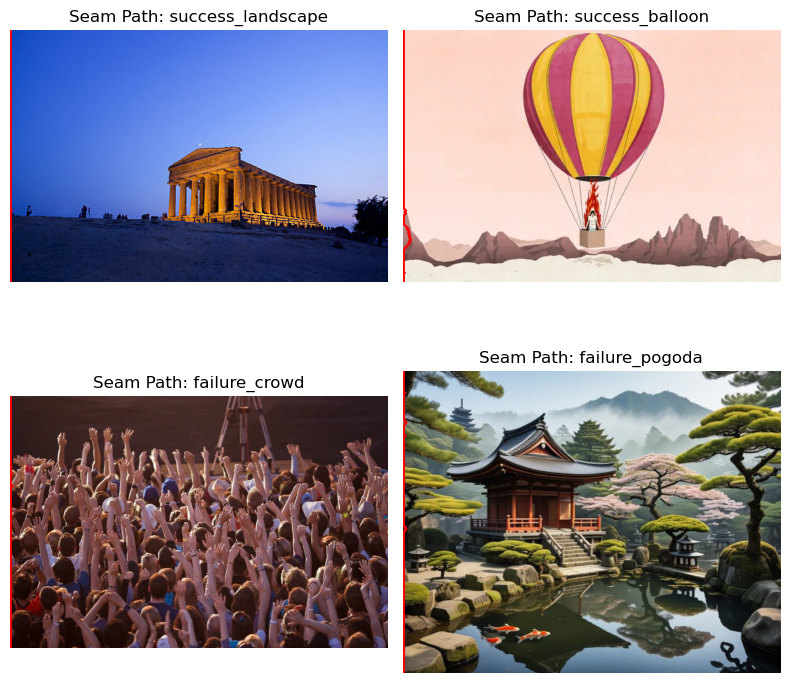

In [75]:
#RED SEAM VISUALIZATION TEST
#Shows where the energy map algorithm thinks the least important path is
#Should be along the "unimportant" parts like the sky or trees

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for i, key in enumerate(all_keys):
    test_img = loaded_images[key].copy()
    h, w, _ = test_img.shape

    energy = calculate_energy(test_img)

    #cost matrix and find vertical seam
    M, backtrack = compute_cost_matrix(energy)
    seam_idx = find_vertical_seam(M, backtrack)

    #draw seam in red
    for r in range(h):
        col = seam_idx[r]
        cv2.circle(test_img, (col, r), 2, (255, 0, 0), -1) 

    axes[i].imshow(test_img)
    axes[i].set_title(f"Seam Path: {key}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Step 4: Iterative Seam Carving

We now integrate all components into a main loop. This function allows us to resize the image by some number of pixels.

The paper notes that a horizontal seam is equivalent to a vertical seam in a transposed image. Therefore, to remove horizontal seams, we rotate the image 90 degrees, run the vertical seam removal, and rotate it back.

In [76]:
def seam_carving(image, target_rows, target_cols):
    """
    Resizes image to target dimensions using Seam Carving.
    """
    current_img = image.copy()
    rows, cols, _ = current_img.shape
    
    #figure out how many seams to remove
    delta_rows = rows - target_rows
    delta_cols = cols - target_cols
    
    print(f"Removing {delta_cols} vertical seams")
    #vertical seam removal (width reduction)
    for _ in tqdm(range(delta_cols)):
        energy = calculate_energy(current_img)
        M, backtrack = compute_cost_matrix(energy)
        seam_idx = find_vertical_seam(M, backtrack)
        current_img = remove_vertical_seam(current_img, seam_idx)

    print(f"Removing {delta_rows} horizontal seams")
    #horizontal seam removal (height reduction)
    #basically just rotate image 90 degrees, remove vertical seams, rotate back
    if delta_rows > 0:
        current_img = np.transpose(current_img, (1, 0, 2)) #rotate 90 degrees
        
        for _ in tqdm(range(delta_rows)):
            energy = calculate_energy(current_img)
            M, backtrack = compute_cost_matrix(energy)
            seam_idx = find_vertical_seam(M, backtrack)
            current_img = remove_vertical_seam(current_img, seam_idx)
            
        current_img = np.transpose(current_img, (1, 0, 2)) #rotate back

    return current_img

## Evaluation
We compare our seam carving result against standard scaling (resizing) to see if the context awareness is occurring. As mentioned in the proposal, success is defined by undistorted important features (like buildings or people) compared to standard scaling.


Processing success_landscape
Removing 150 vertical seams


100%|██████████| 150/150 [01:09<00:00,  2.15it/s]


Removing 0 horizontal seams


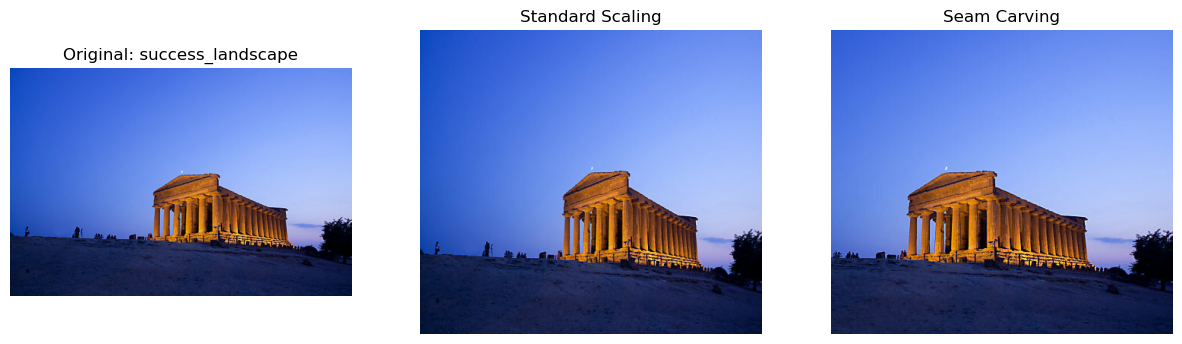


Processing success_balloon
Removing 150 vertical seams


100%|██████████| 150/150 [01:12<00:00,  2.08it/s]

Removing 0 horizontal seams


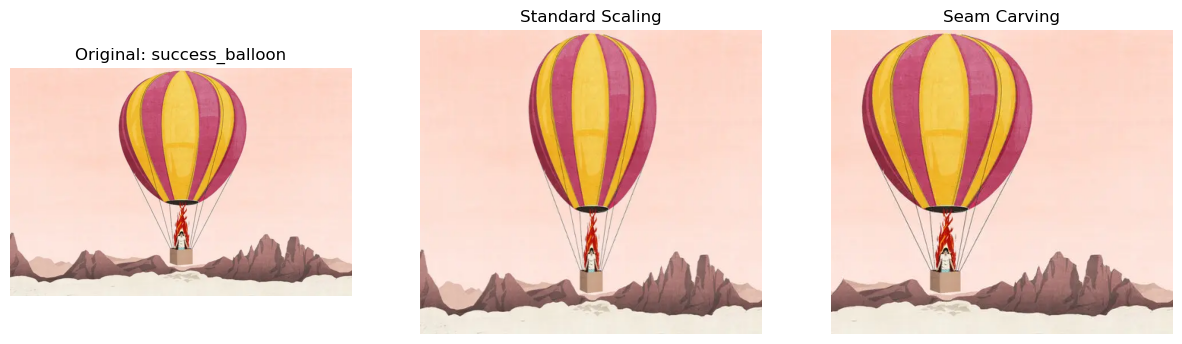

In [77]:
#SUCCESS CASES
SCALE_FACTOR = 0.75  #remove width 50%

for key in success_keys:
    if key not in loaded_images: continue
        
    print(f"\nProcessing {key}")
    original = loaded_images[key]
    h, w, _ = original.shape
    
    target_w = int(w * SCALE_FACTOR)
    target_h = h
    
    #seam carving
    carved_img = seam_carving(original, target_h, target_w)
    
    #standard scaling
    scaled_img = cv2.resize(original, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
    
    show_comparison(original, carved_img, scaled_img, key)

We can see that these images were successfully resized, with the main artifacts in the image not losing their form when resized.

Removing 180 vertical seams


100%|██████████| 180/180 [01:33<00:00,  1.93it/s]


Removing 0 horizontal seams


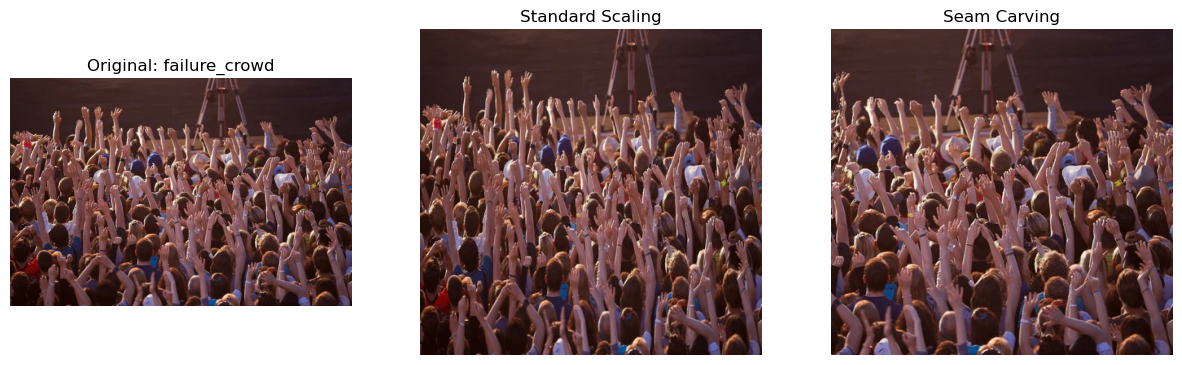

Removing 180 vertical seams


100%|██████████| 180/180 [02:07<00:00,  1.41it/s]


Removing 0 horizontal seams


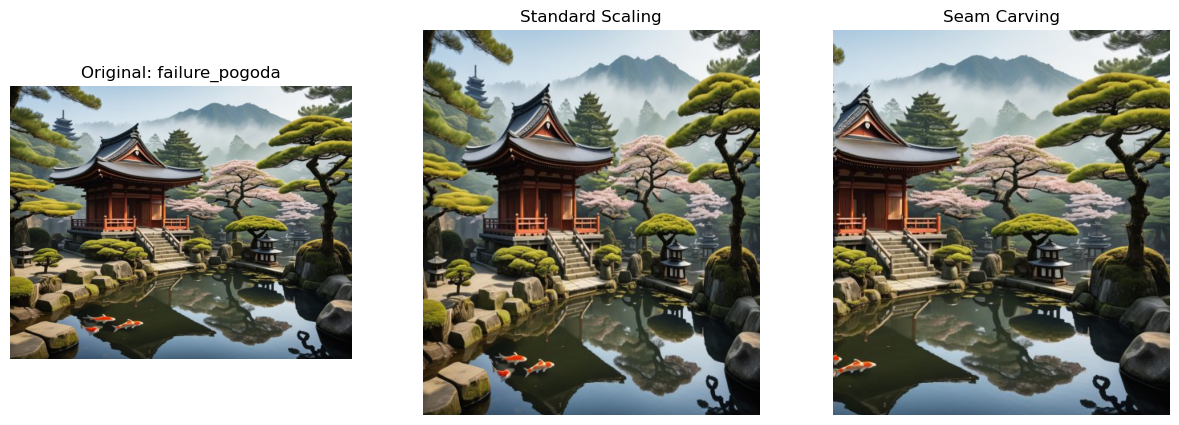

In [78]:
#FAILURE CASES
FAILURE_SCALE = 0.7
for key in failure_keys:
    if key not in loaded_images: continue
    
    original = loaded_images[key]
    h, w, _ = original.shape
    
    target_w = int(w * FAILURE_SCALE)
    carved_img = seam_carving(original, h, target_w)    
    scaled_img = cv2.resize(original, (target_w, h), interpolation=cv2.INTER_LINEAR)
    show_comparison(original, carved_img, scaled_img, key)

We can see that these images were not successfully resized, with the main artifacts in the image losing their form or being cut out entirely.

#### Analysis

Success Case:
The algorithm does a great job with natural scenes, especially where there is a specific object in the image that is different from the rest of the image.

Failure Case:
For the failure cases, we observe the condensed content case with the crowd, where the energy is high everywhere, so the algorithm doesn't do a great job of finding seams and finding what is important. We also see the texture trap scenario, where the algorithm sees the tree as more important as oppposed to the pogoda.

## Step 5: Seam Insertion (Image Widening)

To avoid stretching artifacts, we follow the method in Section 4.3:
1. Find the first $k$ seams that would be removed.
2. Record their coordinates using an index map.
3. Insert new pixels at these recorded locations. The paper says the new pixel value should be an average of the chosen pixel and its neighbor.

In [79]:
#increase width of image by adding vertical seams - section 4.3 of the paper
def insert_vertical_seams(img, num_seams_to_add):
    temp_img = img.copy()
    rows, cols, _ = temp_img.shape
    
    #col indices of the seams
    idx_map = np.tile(np.arange(cols), (rows, 1))
    
    #coords to be duplicated
    seams_to_duplicate = [[] for _ in range(rows)]
        
    #step 1: find seams
    for _ in tqdm(range(num_seams_to_add)):
        energy = calculate_energy(temp_img)
        M, backtrack = compute_cost_matrix(energy)
        seam_idx = find_vertical_seam(M, backtrack)
        
        #record seams
        for r in range(rows):
            current_c = seam_idx[r]
            original_c = idx_map[r, current_c]
            seams_to_duplicate[r].append(original_c)
            
        #remove seams from temp image
        temp_img = remove_vertical_seam(temp_img, seam_idx)
        
        #remove col from map
        new_map = np.zeros((rows, idx_map.shape[1] - 1), dtype=int)
        for r in range(rows):
            c = seam_idx[r]
            new_map[r, :c] = idx_map[r, :c]
            new_map[r, c:] = idx_map[r, c+1:]
        idx_map = new_map

    #step 2: insert seams
    print("Inserting seams")
    
    new_w = cols + num_seams_to_add
    output_img = np.zeros((rows, new_w, 3), dtype=np.uint8)
    
    for r in range(rows):
        cols_to_dup = seams_to_duplicate[r]
        
        #construct new row by pixel
        new_row_pixels = []
        original_row = img[r]
        
        for c in range(cols):
            pixel = original_row[c]
            new_row_pixels.append(pixel)
            
            num_dupes = cols_to_dup.count(c)
            #if marked for duplication, calculate new pixel value via avgs
            for _ in range(num_dupes):                
                if c < cols - 1:
                    right_neighbor = original_row[c+1]
                    new_val = (pixel.astype(int) + right_neighbor.astype(int)) // 2
                else:
                    new_val = pixel #duplicate pixel if edge case
                
                new_row_pixels.append(new_val.astype(np.uint8))
        
        #fill output row
        output_img[r, :len(new_row_pixels)] = np.array(new_row_pixels)[:new_w]

    return output_img

## Evaluation: Widening
Here we test the Seam Insertion on the "Success Beach" image. We will widen it by 50%.
This demonstrates the ability to change aspect ratio while preserving the shape of the waves, contrasting with standard scaling (stretching).


Processing success_boat


100%|██████████| 137/137 [00:11<00:00, 11.83it/s]


Inserting seams


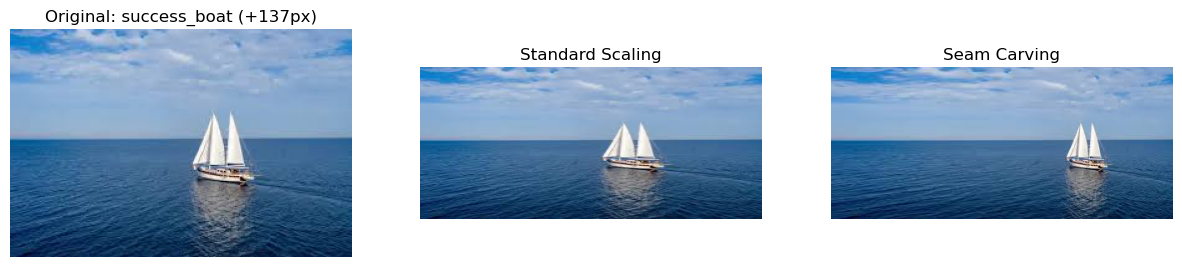


Processing success_plane


100%|██████████| 300/300 [02:05<00:00,  2.40it/s]


Inserting seams


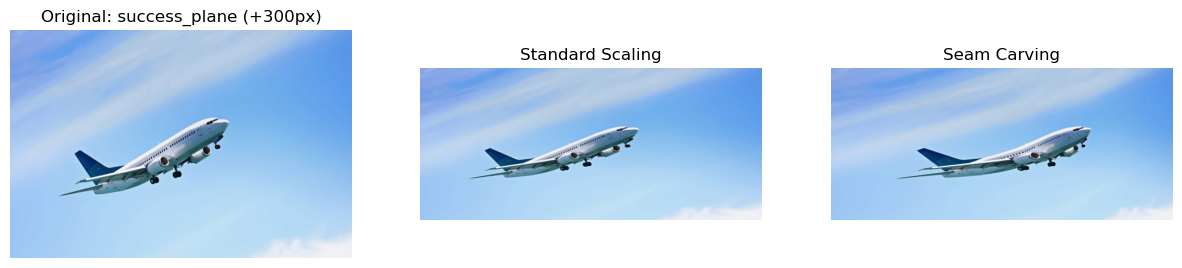

In [88]:
#SEAM INSERTION SUCCESS CASES
WIDEN_FACTOR = 0.5  #increase width by 50%

for key in success_keys_widening:
    if key not in loaded_images: continue
        
    print(f"\nProcessing {key}")
    original = loaded_images[key]
    h, w, _ = original.shape
    
    #get target dims
    seams_to_add = int(w * WIDEN_FACTOR)
    target_w = w + seams_to_add
    
    #seam insertion
    widened_img = insert_vertical_seams(original, seams_to_add)
    
    #standard scaling
    scaled_up = cv2.resize(original, (target_w, h), interpolation=cv2.INTER_LINEAR)
    
    show_comparison(original, widened_img, scaled_up, f"{key} (+{seams_to_add}px)")

We can see that these worked great, with the main artifacts not being widened


Processing failure_crowd


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Inserting seams


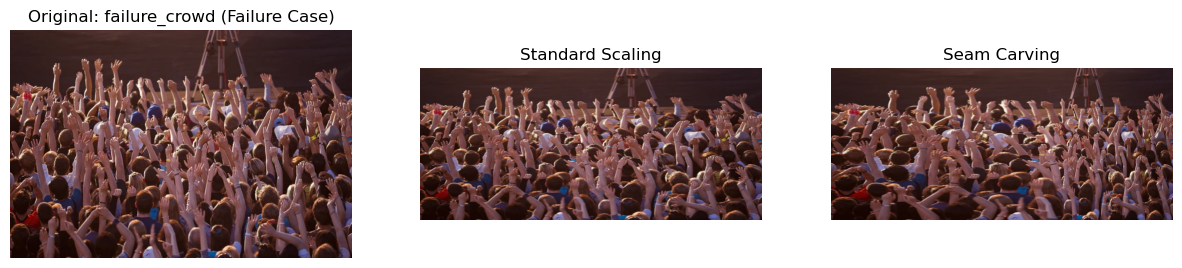


Processing failure_pogoda


100%|██████████| 300/300 [02:45<00:00,  1.81it/s]


Inserting seams


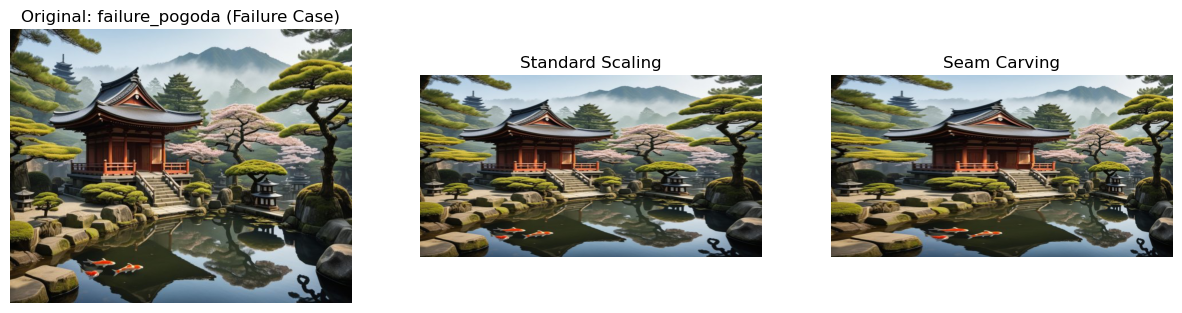

In [81]:
#SEAM INSERTION FAILURE CASES
WIDEN_FACTOR = 0.5 

for key in failure_keys:
    if key not in loaded_images: continue
        
    print(f"\nProcessing {key}")
    original = loaded_images[key]
    h, w, _ = original.shape
    
    seams_to_add = int(w * WIDEN_FACTOR)
    target_w = w + seams_to_add
    
    #seam insertion
    widened_img = insert_vertical_seams(original, seams_to_add)
    
    #standard scaling
    scaled_up = cv2.resize(original, (target_w, h), interpolation=cv2.INTER_LINEAR)
    
    show_comparison(original, widened_img, scaled_up, f"{key} (Failure Case)")

We can see tht these didn't work, with the main artifacts being stretched

#### Analysis

Success Cases: 
For both images, seam insertion does better than standard scaling, expanding the less important aspects of the image while preserving the features of the important aspects of the image.

Failure Cases: 
For the failure cases, we see the people in the crowd being widened, which looks odd, as well as the Pagoda in the Japenese garden image being widened. In both these cases, standard scaling seems to work better or just as bad.

### Citations

* Paper: Avidan, S., & Shamir, A. (2007). Seam carving for content-aware image resizing. ACM Transactions on Graphics (TOG), 26(3), 10.
* Hot air balloon image: https://static01.nyt.com/images/2023/11/07/well/02WELL-UPSIDE-ANGER/02WELL-UPSIDE-ANGER-articleLarge-v3.jpg?quality=75&auto=webp&disable=upscale 
* Crowd image: https://www.shutterstock.com/image-photo/crowd-celebrating-wildly-until-early-600nw-58491475.jpg 
* Parthenon image: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSv4dFXVMusvBjuL4DRjrAn6uuTLle2Fwh5Dg&s 
* Pagoda image: https://img-v3.deepdreamgenerator.com/1308961/md_jrywn0_06893bbc9abe5513a7fcd9d3e1cf7a8191bc908d.jpg 
* Boat image: https://imgx1.yachting.com/getmedia/10f9616e-80e9-41c5-9ee3-63a2a6a60f70/how-to-sail-eco-friendly-a-comprehensive-guid.aspx? 
* Plane image: https://www.shutterstock.com/image-photo/airplane-flying-blue-sky-travel-600nw-2450797723.jpg
